# DeepChords

Multiheaded Root and Chord recognition model.

In [1]:
%matplotlib inline

# Setup autoreload for local modules, otherwise Jupyter caches modules
# on first load. Add new local modules here if necessary.
%load_ext autoreload
%autoreload 2
%aimport deepsamples, helpers, gen_chord_samples, gen_note_samples

# To use specific version
# %pip install --user tensorflow==2.1

Using TensorFlow backend.


# Generate Samples (Option 1)

Download dependencies and generate samples here. Alternatively you can download the pre-generated samples from the next step.

In [ ]:
# Onetime Setup
%pip install midiutil
!sudo apt-get -y install sox fluidsynth
!wget --no-check-certificate https://muthanna.com/deepears/soundfont.sf2

In [93]:
!rm -rf samples
!mkdir -p samples
from gen_chord_samples import gen_chord_samples

from IPython.utils import io

# Supress output. Use terminal to see progress: $ watch 'find samples | wc -l'
with io.capture_output() as captured:
  gen_chord_samples()

Press Enter to start... 


In [94]:
!find samples | wc -l
!sox --i samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav

21601
sox FAIL formats: can't open input file `samples/A2-P0-minor-i0-110.000-S0-V0.29-noreject-attack.wav': No such file or directory


### Upload samples to Storage Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [96]:
!rm samples.zip; zip -q -r samples.zip samples
!ls -l samples.zip

In [99]:
!gsutil -h "Cache-control:public,max-age=86400" -m cp -a public-read samples.zip gs://muthanna.com/deepears/chord-samples-v3.zip

Copying file://samples.zip [Content-Type=application/zip]...
| [1/1 files][188.5 MiB/188.5 MiB] 100% Done                                    
Operation completed over 1 objects/188.5 MiB.                                    


# Download Samples (Option 2)

In [116]:
!wget --no-check-certificate https://muthanna.com/deepears/chord-samples-v3.zip
!rm -rf samples
!unzip -q chord-samples-v3.zip
!ls -l samples/ | wc -l
!ls -l samples | head

--2020-03-16 18:52:19--  https://muthanna.com/deepears/chord-samples-v3.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197661113 (189M) [application/zip]
Saving to: ‘chord-samples-v3.zip’

chord-samples-v3.zi 100%[===================>] 188.50M   126MB/s    in 1.5s    

2020-03-16 18:52:21 (126 MB/s) - ‘chord-samples-v3.zip’ saved [197661113/197661113]

21601
total 259200
-rw-r--r-- 1 jupyter jupyter 10604 Mar 16 17:24 A2-P11-dom7-i0-110.000-S0-V0.94-noreject-attack.wav
-rw-r--r-- 1 jupyter jupyter 10604 Mar 16 17:24 A2-P11-dom7-i0-110.000-S0-V0.94-noreject-decay.wav
-rw-r--r-- 1 jupyter jupyter 10604 Mar 16 17:24 A2-P11-dom7-i0-110.000-S0-V0.94-noreject-sustain.wav
-rw-r--r-- 1 jupyter jupyter 10604 Mar 16 17:24 A2-P11-dom7-i1-110.000-S0-V0.82-noreject-attack.wav
-rw-r--r-- 1 jupyter jupyter 10604 Mar 16 17:24 A2-P11-dom7-i1-110.000-S0-V0.82-no

# Config and Setup

In [2]:
import os
files = os.listdir("samples")
len(files)

21600

In [3]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython import display

import helpers
from helpers import Config
from deepsamples import ChordSamples

Spectrogram for samples/F2-P78-min7-i0-87.307-S0-V0.71-noreject-attack.wav
(257, 67)


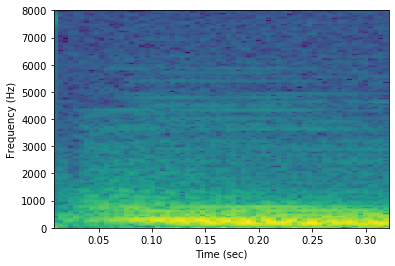

In [4]:
import os

config = Config(
    rows=256,
    cols = 64,
    s_nperseg = 256,
    s_nfft = 512,
    s_noverlap = 180,
    log_scale = True,
    clip_magnitude_quantile=0.25,
    resample = 16000)

helpers.spectrogram_from_file("samples/"+files[250], config=config)
None

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Loading sample files...
Shuffling samples...
Generating spectrograms...


[                                                            ] 0/10

Normalizing data...
Samples ready.
C4-P66-dim-i2-261.626-S0-V0.81-noreject-attack.wav
C
dim


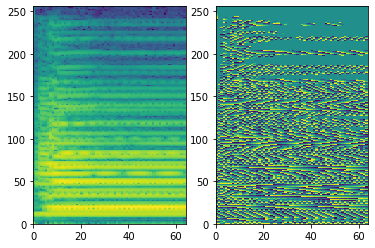

In [5]:
example = 4
samples = ChordSamples(num_samples=10, config=config)
samples.load()

print(samples.files[example])
print(samples.root_classes[np.argmax(samples.root_ys[example])])
print(samples.chord_classes[np.argmax(samples.chord_ys[example])])

plt.subplot(1, 2, 1)
plt.pcolormesh(samples.mags[example])
plt.subplot(1, 2, 2)
plt.pcolormesh(samples.phases[example])

In [6]:
def plot_history(history):
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("loss"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.figure()
    
  for k in history.history:
    vals = history.history[k]
    
    if k.endswith("accuracy"):
        plt.plot(vals, label=k)

  plt.legend()
  plt.show()

# DeepChords Models

In [7]:
import re
import sys
import os

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

## Multiheaded Model

This model has two inputs and two outputs. Magnitudes are run through a conv layer, and Phases through an RNN. Extracted features are sent to two dense layers, one emitting chords, and the other roots.

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mags (InputLayer)               [(None, 256, 64)]    0                                            
__________________________________________________________________________________________________
phases (InputLayer)             [(None, 256, 64)]    0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 64, 1)   0           mags[0][0]                       
__________________________________________________________________________________________________
permute (Permute)               (None, 64, 256)      0           phases[0][0]                     
___________________________________

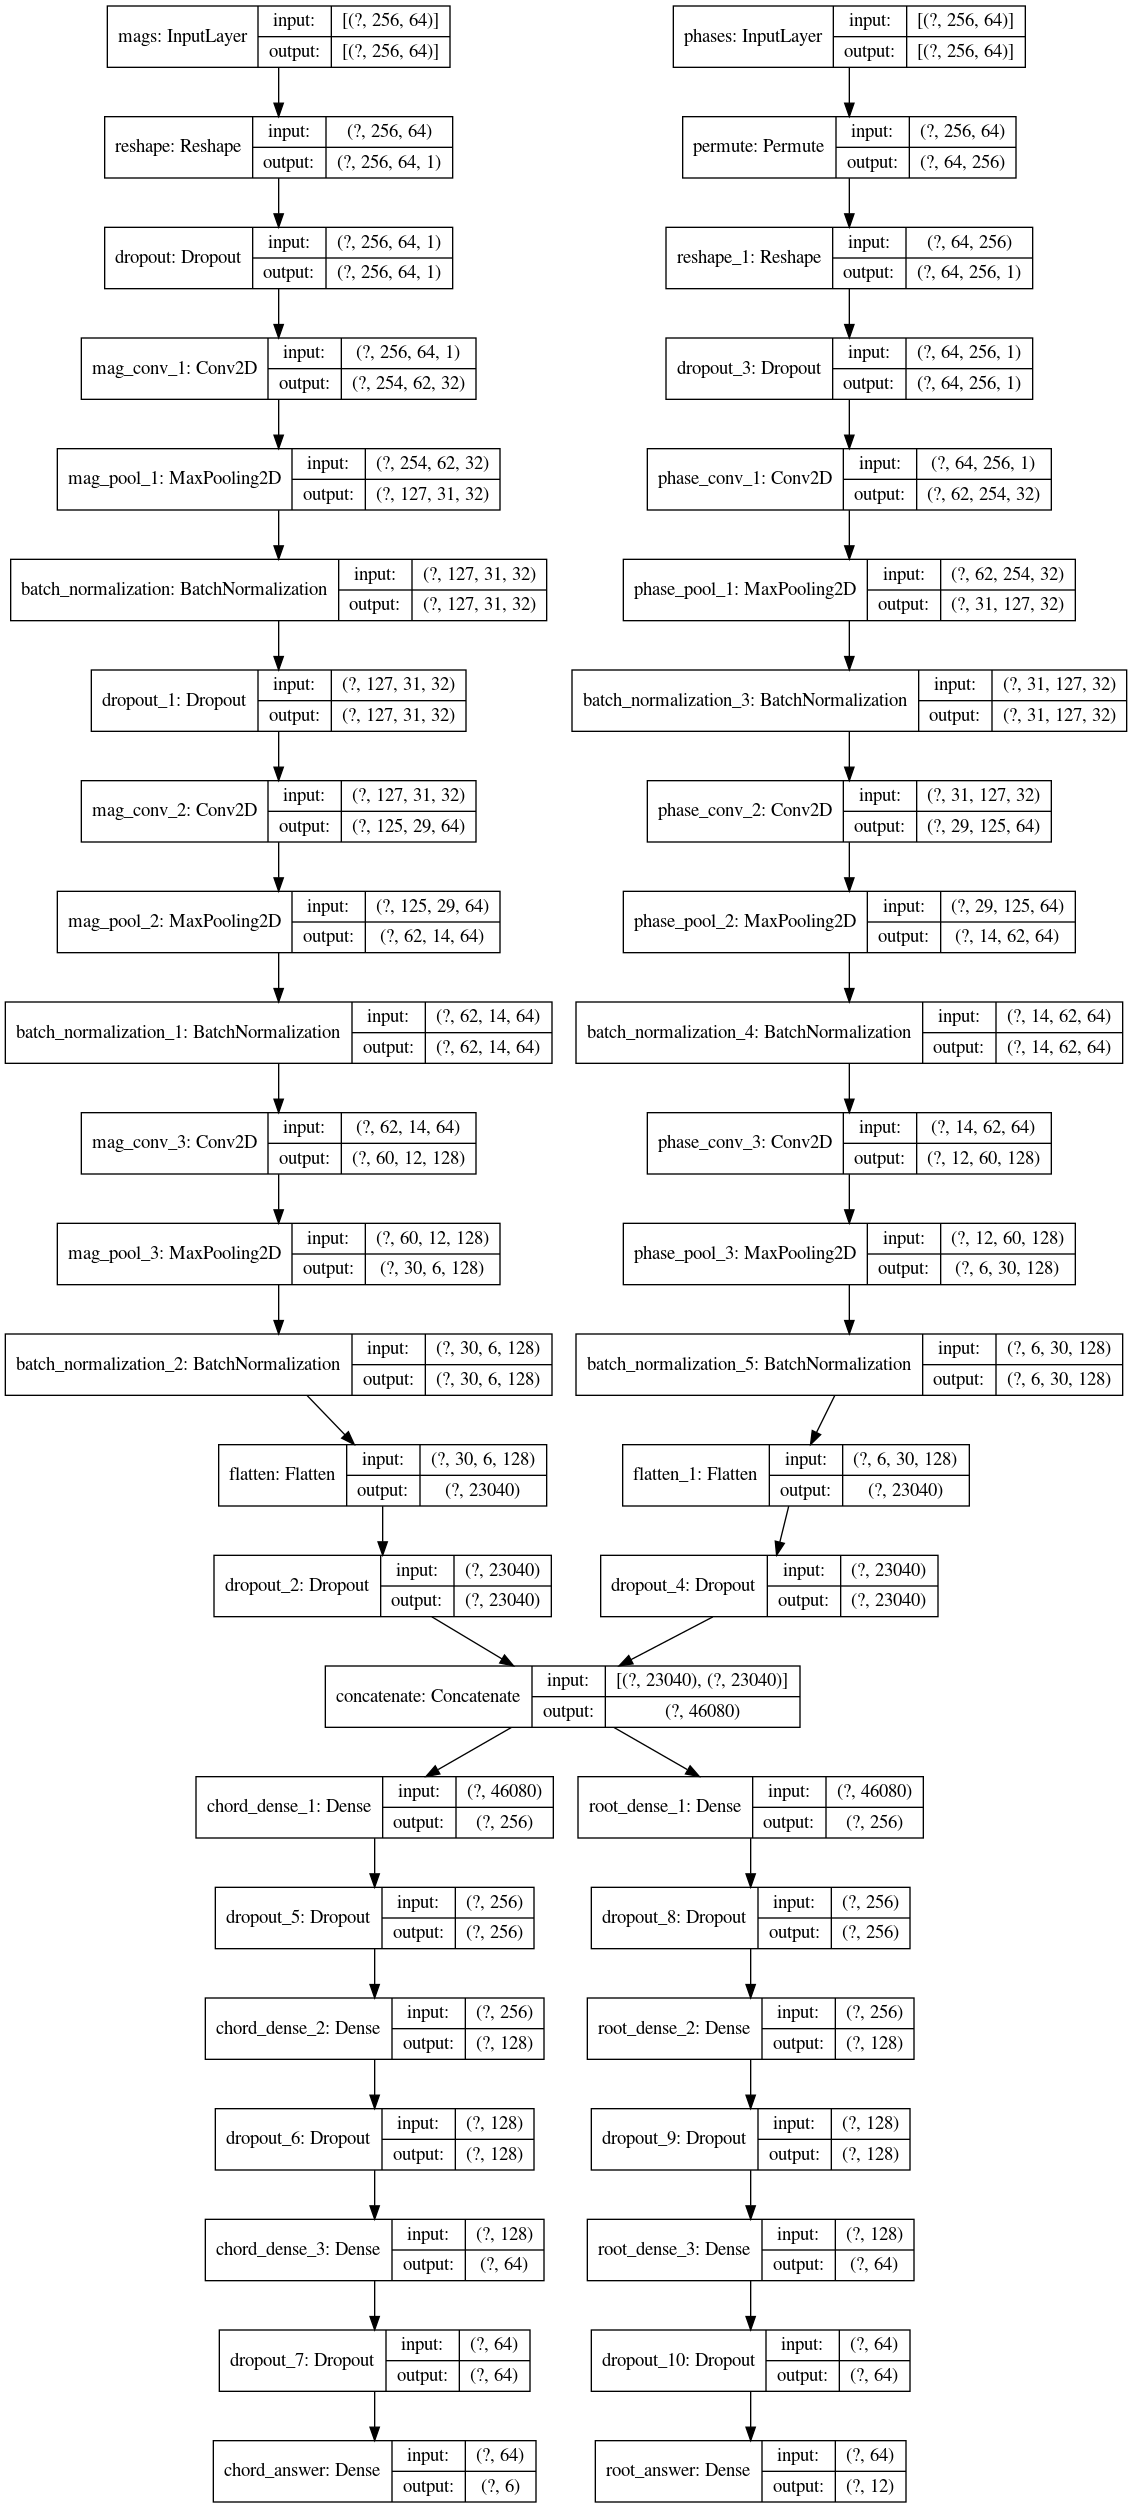

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

dummy_samples = ChordSamples(num_samples=10, config=config)

rows = config.rows
cols = config.cols

mags_input = layers.Input(shape=(rows, cols), name='mags')
phases_input = layers.Input(shape=(rows, cols), name='phases')

mag_layers = layers.Reshape((rows, cols, 1))(mags_input)
mag_layers = layers.Dropout(0.2)(mag_layers)
mag_layers = layers.Conv2D(32, (3,3), activation='relu', name="mag_conv_1")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_1")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Dropout(0.2)(mag_layers)
mag_layers = layers.Conv2D(64, (3,3), activation='relu', name="mag_conv_2")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_2")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Conv2D(128, (3,3), activation='relu', name="mag_conv_3")(mag_layers)
mag_layers = layers.MaxPooling2D(pool_size=(2,2), name="mag_pool_3")(mag_layers)
mag_layers = layers.BatchNormalization()(mag_layers)
mag_layers = layers.Flatten()(mag_layers)
mag_layers = layers.Dropout(0.2)(mag_layers)

phase_layers = layers.Permute((2, 1))(phases_input)
phase_layers = layers.Reshape((cols, rows, 1))(phase_layers)
phase_layers = layers.Dropout(0.2)(phase_layers)
phase_layers = layers.Conv2D(32, (3,3), activation='relu', name="phase_conv_1")(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_1")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Conv2D(64, (3,3), activation='relu', name="phase_conv_2")(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_2")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Conv2D(128, (3,3), name="phase_conv_3", activation='relu')(phase_layers)
phase_layers = layers.MaxPooling2D(pool_size=(2,2), name="phase_pool_3")(phase_layers)
phase_layers = layers.BatchNormalization()(phase_layers)
phase_layers = layers.Flatten()(phase_layers)
phase_layers = layers.Dropout(0.2)(phase_layers)

concatenated = layers.concatenate([mag_layers, phase_layers])

chord_layers = layers.Dense(256, activation='relu', name='chord_dense_1')(concatenated)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_layers = layers.Dense(128, activation='relu', name='chord_dense_2')(chord_layers)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_layers = layers.Dense(64, activation='relu', name='chord_dense_3')(chord_layers)
chord_layers = layers.Dropout(0.2)(chord_layers)
chord_answer = layers.Dense(len(dummy_samples.chord_classes), activation='softmax', name='chord_answer')(chord_layers)

root_layers = layers.Dense(256, activation='relu', name='root_dense_1')(concatenated)
root_layers = layers.Dropout(0.2)(root_layers)
root_layers = layers.Dense(128, activation='relu', name='root_dense_2')(root_layers)
root_layers = layers.Dropout(0.2)(root_layers)
root_layers = layers.Dense(64, activation='relu', name='root_dense_3')(root_layers)
root_layers = layers.Dropout(0.2)(root_layers)
root_answer = layers.Dense(len(dummy_samples.root_classes), activation='softmax', name='root_answer')(root_layers)

model = tf.keras.models.Model([mags_input, phases_input], [chord_answer, root_answer])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer, metrics=['accuracy'])

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, )
display.display(display.Image("model.png"))

In [9]:
total_samples = 1000
training_samples = int(total_samples * 0.8)

prod_samples = ChordSamples(num_samples=total_samples, config=config)
prod_samples.load()

Initializing DeepSamples:ChordSamples...
rows/cols: 256 64
Loading sample files...
Shuffling samples...
Generating spectrograms...


[=========================================================   ] 950/1000

Normalizing data...
Samples ready.


In [14]:
from tensorboard import notebook
notebook.list()

No known TensorBoard instances running.


In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard("./logs", histogram_freq=1)
history = model.fit([prod_samples.mags[:training_samples], prod_samples.phases[:training_samples]], [prod_samples.chord_ys[:training_samples], prod_samples.root_ys[:training_samples]], epochs=25, batch_size=64, validation_split=0.2,
                   callbacks=[tensorboard_callback])
plot_history(history)

Train on 13600 samples, validate on 3400 samples
Epoch 1/25
13600/13600 [==============================] - 57s 4ms/sample - loss: 3.6092 - chord_answer_loss: 1.9203 - root_answer_loss: 1.6858 - chord_answer_accuracy: 0.2675 - root_answer_accuracy: 0.4759 - val_loss: 2.8092 - val_chord_answer_loss: 1.6210 - val_root_answer_loss: 1.1926 - val_chord_answer_accuracy: 0.3088 - val_root_answer_accuracy: 0.6703
Epoch 2/25
13600/13600 [==============================] - 37s 3ms/sample - loss: 1.8842 - chord_answer_loss: 1.2017 - root_answer_loss: 0.6831 - chord_answer_accuracy: 0.5145 - root_answer_accuracy: 0.7843 - val_loss: 1.1614 - val_chord_answer_loss: 0.7782 - val_root_answer_loss: 0.3816 - val_chord_answer_accuracy: 0.7068 - val_root_answer_accuracy: 0.8703
Epoch 3/25
13600/13600 [==============================] - 37s 3ms/sample - loss: 1.3029 - chord_answer_loss: 0.8594 - root_answer_loss: 0.4427 - chord_answer_accuracy: 0.6649 - root_answer_accuracy: 0.8643 - val_loss: 0.8682 - val_ch

KeyboardInterrupt: 

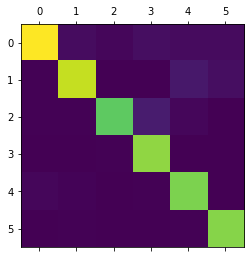

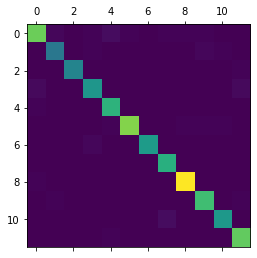

In [115]:
predictions = model.predict([prod_samples.mags[training_samples:], prod_samples.phases[training_samples:]])
chord_predictions = np.argmax(predictions[0], axis=-1)
root_predictions = np.argmax(predictions[1], axis=-1)

chord_labels = np.argmax(prod_samples.chord_ys[training_samples:], axis=1)
root_labels = np.argmax(prod_samples.root_ys[training_samples:], axis=1)
plt.matshow(tf.math.confusion_matrix(chord_predictions, chord_labels))
plt.matshow(tf.math.confusion_matrix(root_predictions, root_labels))

(1, 254, 62, 32)


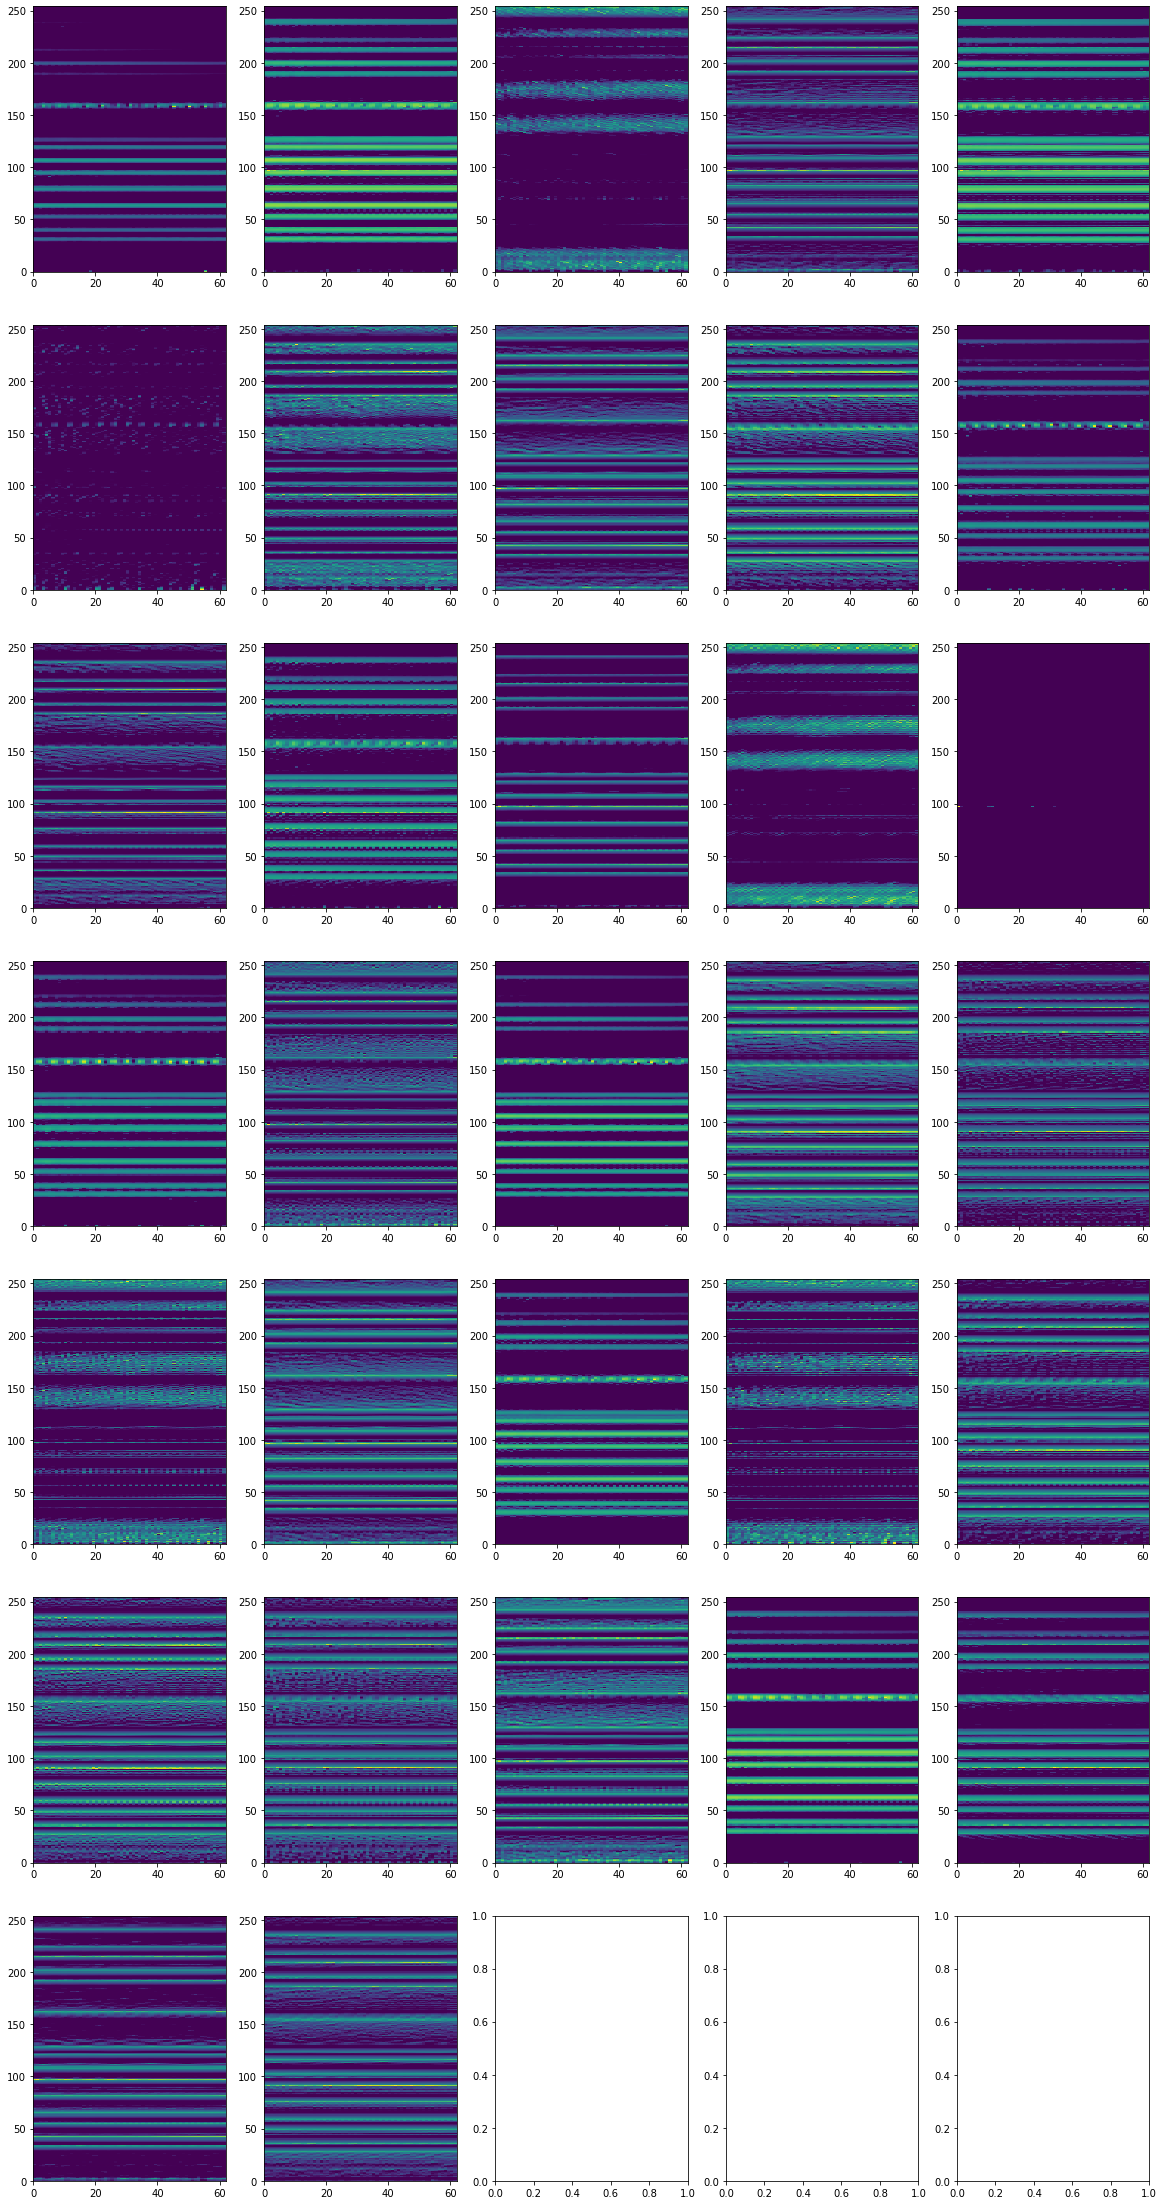

In [117]:
def visualize_filters(layer_num, count, x, model=model):
  layer = model.get_layer(index=layer_num)
  layer_output=layer.output
  
  intermediate_model=tf.keras.models.Model(inputs=model.inputs,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x)

  col_size=5
  row_size=int(count / col_size) + 1
  
  print(np.shape(intermediate_prediction))
  fig,ax=plt.subplots(row_size,col_size,figsize=(20,40))

  img_index=0
  row=0
  col=0
  while img_index < count:
    ax[row][col].pcolormesh(intermediate_prediction[0, :, :, img_index])
    img_index=img_index+1
    col += 1
    if col >= col_size:
      col = 0
      row +=1
    if img_index > count: break

visualize_filters(6, 32, x=[prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)])

mags: 64 (1, 256, 64)
phases: 64 (1, 256, 64)
reshape_35: 1 (1, 256, 64, 1)
permute_18: 256 (1, 64, 256)
dropout_168: 1 (1, 256, 64, 1)
reshape_36: 1 (1, 64, 256, 1)
mag_conv_1: 32 (1, 254, 62, 32)
dropout_171: 1 (1, 64, 256, 1)
mag_pool_1: 32 (1, 127, 31, 32)
phase_conv_1: 32 (1, 62, 254, 32)
batch_normalization_7: 32 (1, 127, 31, 32)
phase_pool_1: 32 (1, 31, 127, 32)
dropout_169: 32 (1, 127, 31, 32)
batch_normalization_10: 32 (1, 31, 127, 32)
mag_conv_2: 64 (1, 125, 29, 64)
phase_conv_2: 64 (1, 29, 125, 64)
mag_pool_2: 64 (1, 62, 14, 64)
phase_pool_2: 64 (1, 14, 62, 64)
batch_normalization_8: 64 (1, 62, 14, 64)
batch_normalization_11: 64 (1, 14, 62, 64)
mag_conv_3: 128 (1, 60, 12, 128)
phase_conv_3: 128 (1, 12, 60, 128)
mag_pool_3: 128 (1, 30, 6, 128)
phase_pool_3: 128 (1, 6, 30, 128)
batch_normalization_9: 128 (1, 30, 6, 128)
batch_normalization_12: 128 (1, 6, 30, 128)
flatten_33: 23040 (1, 23040)
flatten_34: 23040 (1, 23040)
dropout_170: 23040 (1, 23040)
dropout_172: 23040 (1, 2304

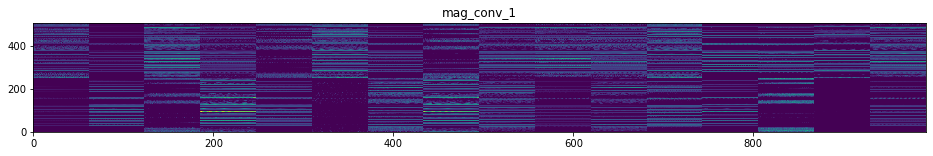

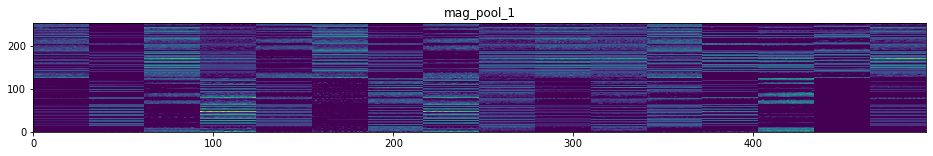

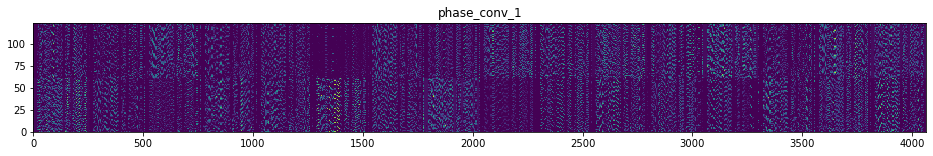

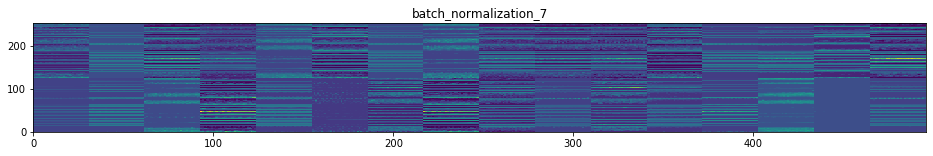

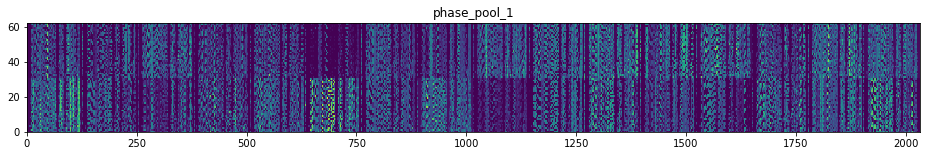

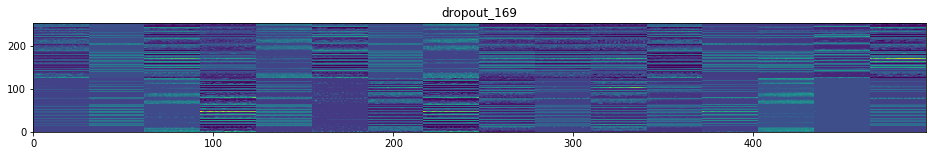

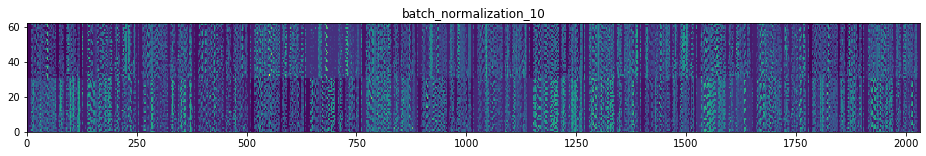

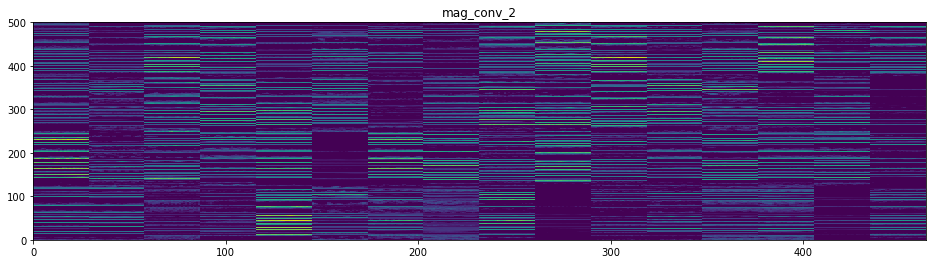

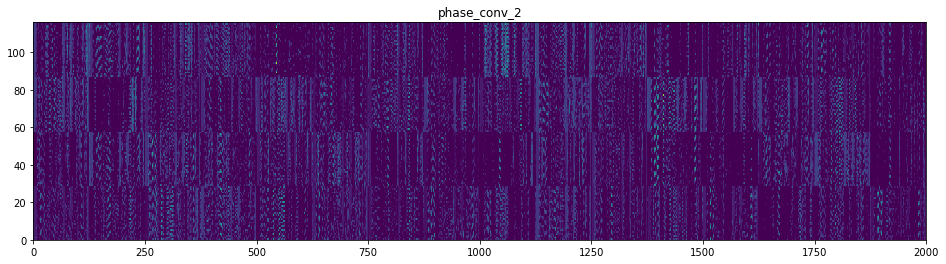

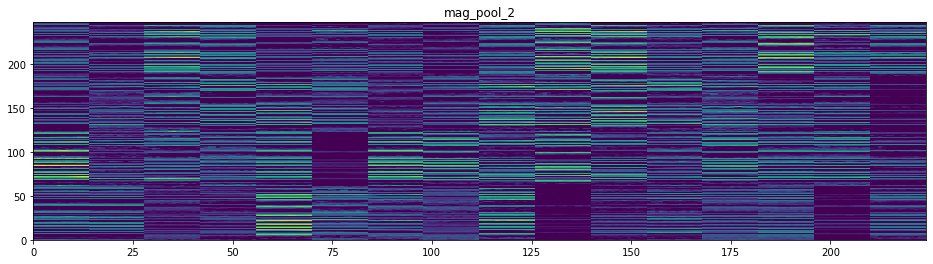

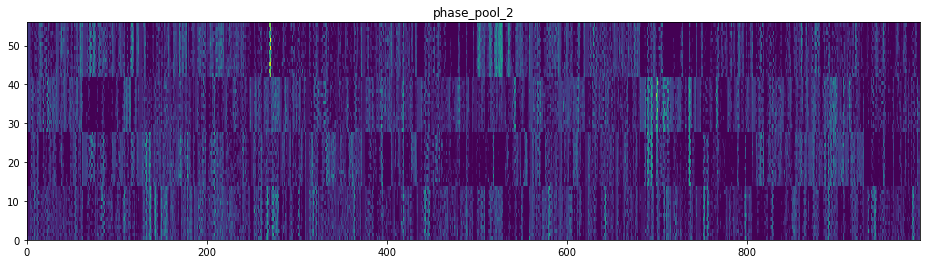

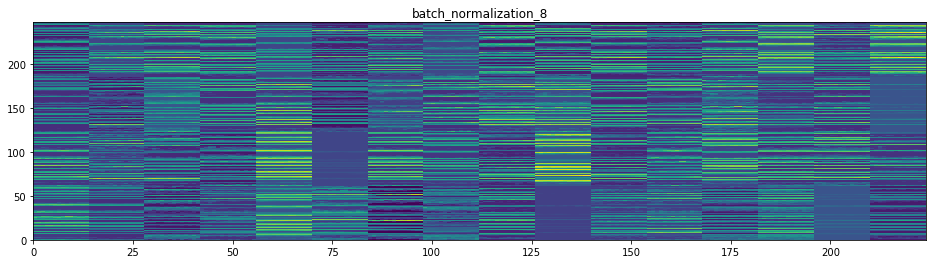

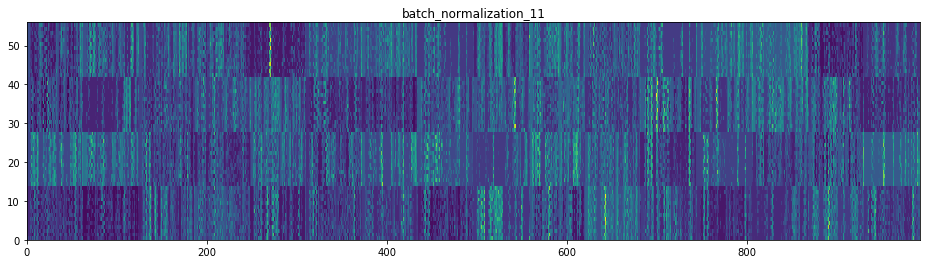

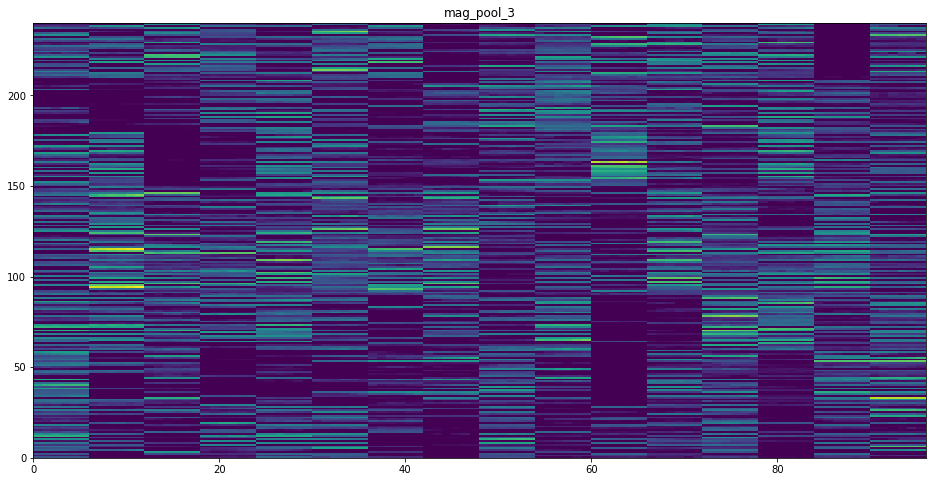

In [129]:
from keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.compat.v1.keras.Model(inputs=model.inputs, outputs=layer_outputs)

activations = activation_model.predict([prod_samples.mags[0].reshape(1, rows, cols), prod_samples.phases[0].reshape(1, rows, cols)]) 

layer_names = []
for layer in model.layers:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  n_cols = n_features // images_per_row
  print("%s:" % layer_name, n_features, layer_activation.shape)
  if len(layer_activation.shape) < 4:
    continue

  if n_cols == 0:
    continue

  col_size = layer_activation.shape[1]
  row_size = layer_activation.shape[2]

  display_grid = np.zeros((col_size * n_cols, images_per_row * row_size))

  for col in range(n_cols):
      for row in range(images_per_row):
          channel_image = layer_activation[0, :, :, col * images_per_row + row]
          display_grid[col * col_size : (col + 1) * col_size, row * row_size : (row + 1) * row_size] = channel_image
    
  col_scale =1. / col_size
  row_scale =1. / row_size

  plt.figure(figsize=(row_scale * display_grid.shape[1], col_scale * display_grid.shape[0]))
  
  plt.title(layer_name)
  plt.grid(False)
  plt.pcolormesh(display_grid)

# Save Models

In [ ]:
# Auth this runtime to GCP (once only)
from google.colab import auth
auth.authenticate_user()

In [121]:
model.save("deepchords_model_v1.h5")
!ls -lh *.h5

-rw-r--r-- 1 jupyter jupyter 365M Mar 16 18:54 deepchords_model_v1.h5


In [122]:
!gsutil -m cp -a public-read *.h5 gs://muthanna.com/deepears

Copying file://deepchords_model_v1.h5 [Content-Type=application/octet-stream]...
\ [1/1 files][364.4 MiB/364.4 MiB] 100% Done                                    
Operation completed over 1 objects/364.4 MiB.                                    


In [127]:
old_model = model
new_model = tf.keras.models.load_model("deepchords_model_v1.h5")

In [128]:
model = new_model

# Live Test

In [124]:
!wget --no-check-certificate https://muthanna.com/deepears/sweetchild.wav

--2020-03-16 18:55:34--  https://muthanna.com/deepears/sweetchild.wav
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-03-16 18:55:35 ERROR 404: Not Found.



In [ ]:
fs, data = wavfile.read('sweetchild-8bit.wav')
sample_len = int(8000 * 0.33) # 0.33ms slice of 8khz audio
num_samples = int(len(data) / sample_len)
remainder = len(data) % sample_len

samples = np.reshape(data[0:len(data) - remainder], (num_samples, sample_len))

In [ ]:
for i in range(0, num_samples):
  f, t, Sxx = signal.spectrogram(samples[i], fs, window=('hann'), nperseg=64, nfft=128, noverlap=16, mode='magnitude')
  Sxx = Sxx.reshape(1, 65, 54,1)
  root_class = deepears.root_model.predict_classes(Sxx)
  chord_class = deepears.chord_model.predict_classes(Sxx)
  
  chord = deepears.get_chord_classes()[int(chord_class)]
  root = deepears.get_root_classes()[int(root_class)]
  print(i * 0.33, "seconds:", root, chord)


0.0 seconds: Cs min7
0.33 seconds: Cs dom7
0.66 seconds: D dom7
0.99 seconds: As dom7
1.32 seconds: D dom7
1.6500000000000001 seconds: Fs dom7
1.98 seconds: Cs dom7
2.31 seconds: Fs min7
2.64 seconds: E maj7
2.97 seconds: D dom7
3.3000000000000003 seconds: F major
3.6300000000000003 seconds: D maj7
3.96 seconds: Cs min7
4.29 seconds: Fs sus2
4.62 seconds: Ds dom7
4.95 seconds: Ds dom7
5.28 seconds: Ds min7
5.61 seconds: Fs dom7
5.94 seconds: D dom7
6.2700000000000005 seconds: Cs dom7
6.6000000000000005 seconds: Cs dom7
6.930000000000001 seconds: D min7
7.260000000000001 seconds: Cs dom7
7.590000000000001 seconds: D dom7
7.92 seconds: Fs dom7
8.25 seconds: D dom7
8.58 seconds: G min7
8.91 seconds: Fs minor
9.24 seconds: D dom7
9.57 seconds: D dom7
9.9 seconds: B min7
10.23 seconds: Ds dom7
10.56 seconds: Fs dom7
10.89 seconds: Fs dom7
11.22 seconds: Cs dom7
11.55 seconds: C dom7
11.88 seconds: B maj7
12.21 seconds: Cs dom7
12.540000000000001 seconds: As dom7
12.870000000000001 seconds: 